# Fraguracy error rate

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import numpy as np
from pathlib import Path
run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/error_rate/fraguracy")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

## Error rate

In [2]:
runs=["aviti_hq", "aviti_ngi", "xplus_sns"]
cells = ["OPM2", "KMS12BM", "MM1S", "REH"]

data = []
for run in runs:
    for cell in cells:
        file = basedir / f"{run}_{cell}{cell}_{cell}-counts.txt"
        df = pd.read_csv(file, sep="\t")
        df["run"] = run
        df["Cell line"] = cell

        data.append(df)


data = pd.concat(data)
data["Data source"] = data["run"].replace(run_names)
data = data[data["total_count"] > 0]
data.head()

,read12,FR,bq_bin,read_pos,context,hp_dist,total_count,error_count,err_rate_lo,err_rate_hi,run,Cell line,Data source
127,r1,f,0-5,0,CA,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB
159,r1,f,0-5,0,CG,NaN,1,1,0.167494,1.039049,aviti_hq,OPM2,AVITI CB
191,r1,f,0-5,0,CT,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB
223,r1,f,05-19,0,AC,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB
255,r1,f,05-19,0,AG,NaN,1,0,0.000000,0.832506,aviti_hq,OPM2,AVITI CB


/Users/pontus.hojer/miniconda3/envs/aviti/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/pontus.hojer/miniconda3/envs/aviti/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


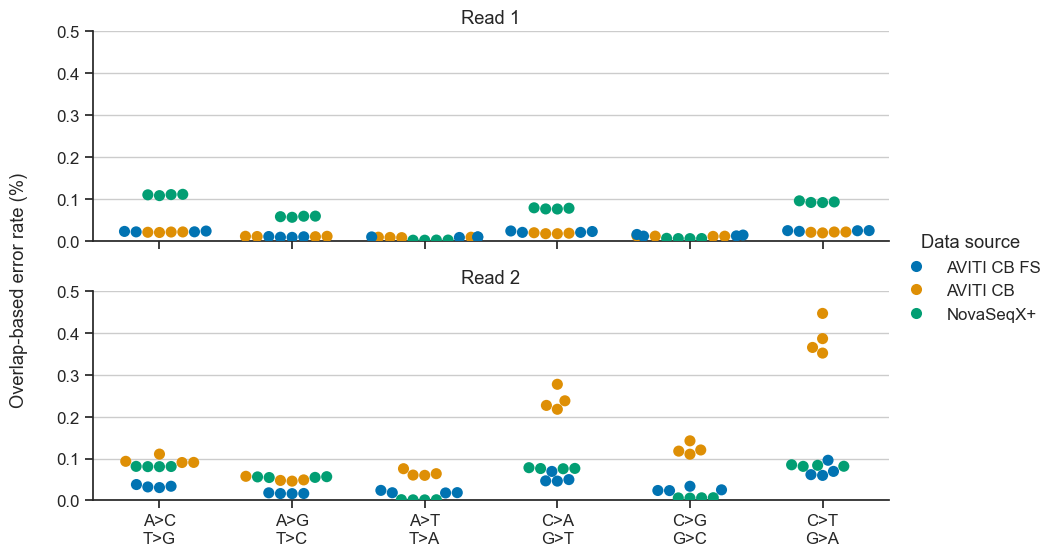

In [3]:
def norm(x):
    error_rates = x["error_count"] / x["total_count"]
    total_rate = x["error_count"].sum() / x["total_count"].sum()
    print(error_rates)
    return pd.Series(error_rates - total_rate)

def rename_context(x):
    complement = {
        "A": "T",
        "T": "A",
        "G": "C",
        "C": "G"
    }
    bases = list(x)
    comp_bases = [complement[b] for b in bases]

    sub = ">".join(bases)
    comp_sub = ">".join(comp_bases)
    return f"{sub}\n{comp_sub}"

d = data.groupby(["Data source", "Cell line", "context", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
d["error_rate"] = 100 * d["error_count"] / d["total_count"]

d["error_count_total"] = d.groupby(
    ["Data source", "Cell line", "read12"]
    )["error_count"].transform(lambda x: [x.sum()]*len(x))
d["total_count_total"] = d.groupby(
    ["Data source", "Cell line", "read12"]
    )["total_count"].transform(lambda x: [x.sum()]*len(x))
d["error_rate_total"] = 100 * d["error_count_total"] / d["total_count_total"]
d["error_rate_norm"] = d["error_rate"] - d["error_rate_total"]

d["Context"] = d["context"].apply(rename_context)
d["Read"] = d["read12"].str.replace("r", "Read ")

g = sns.catplot(d, kind="swarm", x="Context", y="error_rate", hue="Data source",
            hue_order=run_names.values(), row="Read", aspect=3, height=3, size=8)
#g.map_dataframe(sns.barplot, data=d, x="Context", y="error_rate", hue="Data source", fill=False, hue_order=run_names.values(), palette="colorblind")
g.set_titles("{row_name}")
g.set(ylabel="", xlabel="", ylim=(0, 0.5))
for ax in g.axes.flat:
    ax.grid(True, axis="y")
g.figure.text(0.01, 0.5, "Overlap-based error rate (%)", va="center", rotation=90)
g.figure.savefig(figdir / "error_rate_overlap_by_read_and_context.svg", dpi=300, bbox_inches="tight", transparent=True)


### Redirect reads to match orientations

In [4]:
data_inv = data.copy()

# Flip reverse oriented reads to match f positions
data_inv.loc[data_inv.FR == "r", "read_pos"] = np.abs(data_inv.loc[data_inv.FR == "r", "read_pos"] - 150)
data_inv["Cycle"] = data_inv["read_pos"]
data_inv.loc[data_inv.read12 == "r2", "Cycle"] = data_inv.loc[data_inv.read12 == "r2", "Cycle"] + 150
data_inv = data_inv.groupby(["Data source", "Cell line", "Cycle", "read12"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
data_inv["Mismatches per base"] = 100  * data_inv["error_count"] / data_inv["total_count"]

# Normalize data across cell lines and make minimum zero
data_inv["Mismatches per base norm"] = data_inv.groupby(["Cell line", "read12"])["Mismatches per base"].transform(
    lambda x: x - x.median()
)

# Smooth data
data_inv["Mismatches per base smoothed"] = data_inv.groupby(["Data source", "Cell line", "read12"])["Mismatches per base"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
data_inv["Mismatches per base norm smoothed"] = data_inv.groupby(["Data source", "Cell line", "read12"])["Mismatches per base norm"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
data_inv

,Data source,Cell line,Cycle,read12,total_count,error_count,Mismatches per base,Mismatches per base norm,Mismatches per base smoothed,Mismatches per base norm smoothed
0,AVITI CB,KMS12BM,0,r1,36729,5,0.013613,-0.001854,NaN,NaN
1,AVITI CB,KMS12BM,1,r1,74499,3,0.004027,-0.011440,NaN,NaN
2,AVITI CB,KMS12BM,2,r1,77712,3,0.003860,-0.011607,0.007683,-0.007784
3,AVITI CB,KMS12BM,3,r1,81048,7,0.008637,-0.006830,0.006326,-0.009142
4,AVITI CB,KMS12BM,4,r1,84564,7,0.008278,-0.007189,0.008157,-0.007311
...,...,...,...,...,...,...,...,...,...,...
3619,NovaSeqX+,REH,296,r2,2258340,1449,0.064162,0.011734,0.070304,0.017876
3620,NovaSeqX+,REH,297,r2,2305983,1626,0.070512,0.018084,0.071231,0.018804
3621,NovaSeqX+,REH,298,r2,2355342,1704,0.072346,0.019918,0.073169,0.020741
3622,NovaSeqX+,REH,299,r2,2405580,1916,0.079648,0.027220,NaN,NaN


[None]

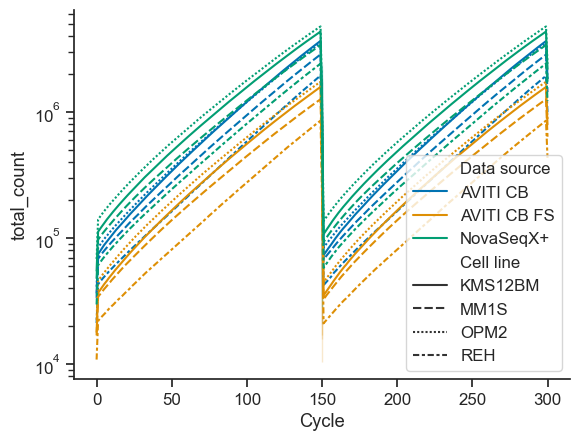

In [5]:
#d = data_inv.groupby(["run", "FR", "Cycle"]).agg({"total_count": "sum", "error_count": "sum"}).reset_index()
g = sns.lineplot(data_inv, x="Cycle", y="total_count", hue="Data source", style="Cell line",)
g.set(yscale="log")

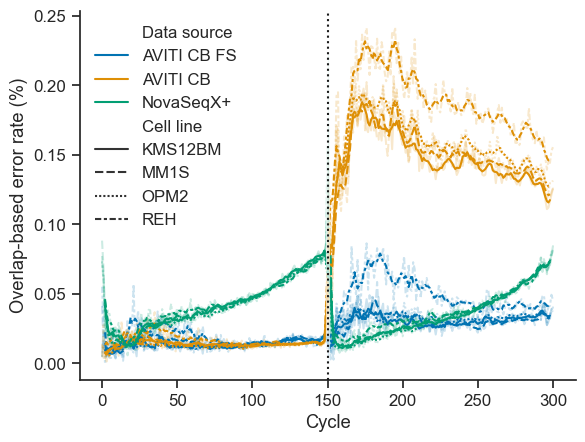

In [6]:

ax = sns.lineplot(data_inv, x="Cycle", y="Mismatches per base", hue="Data source", 
                hue_order=run_names.values(), 
                style="Cell line", alpha=0.2, legend=False)
ax = sns.lineplot(data_inv, x="Cycle", y="Mismatches per base smoothed", hue="Data source", 
                hue_order=run_names.values(), 
                style="Cell line")
ax.set_xlabel("Cycle")
ax.set_ylabel("Overlap-based error rate (%)")
ax.legend(frameon=False, framealpha=0)
ax.axvline(150.5, color="k", ls=":", zorder=3)
ax.axvline(150.5, color="w", lw=3, alpha=0.7, zorder=2)

fig = ax.get_figure()
fig.savefig(figdir / "error_rate_overlap_by_cycle.svg")


                   Mismatches per base          
                                   min       max
Data source read12                              
AVITI CB    r1                0.011911  0.014918
            r2                0.142198  0.185969
AVITI CB FS r1                0.011234  0.014891
            r2                0.027327  0.046114
NovaSeqX+   r1                0.038573  0.041544
            r2                0.032848  0.035471


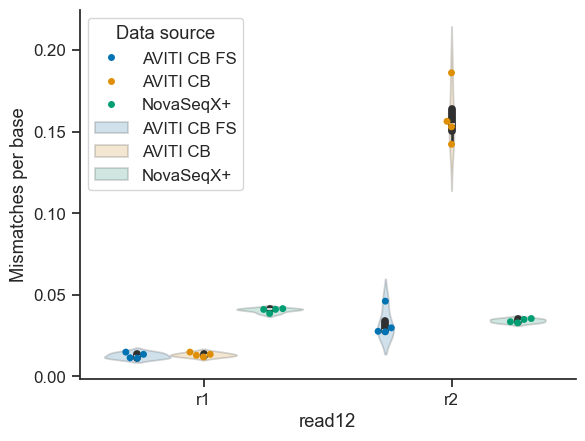

In [7]:
d = data_inv.copy()
positions = list(np.arange(int(150*0.5), int(150*0.6)))
positions += list(np.arange(int(150*0.5), int(150*0.6)) + 150)
d = d.query("Cycle in @positions")
d = d.groupby(["Data source", "Cell line", "read12"]).agg({"Mismatches per base": "median"}).reset_index()
sns.swarmplot(d, x="read12", y="Mismatches per base", hue="Data source", dodge=True, hue_order=run_names.values())
sns.violinplot(d, x="read12", y="Mismatches per base", hue="Data source", dodge=True, hue_order=run_names.values(), alpha=0.2)
print(d.groupby(["Data source", "read12"]).agg({"Mismatches per base": ["min", "max"]}))

            Mismatches per base          
                            min       max
Data source                              
AVITI CB               0.075573  0.098790
AVITI CB FS            0.018620  0.028752
NovaSeqX+              0.036227  0.039691


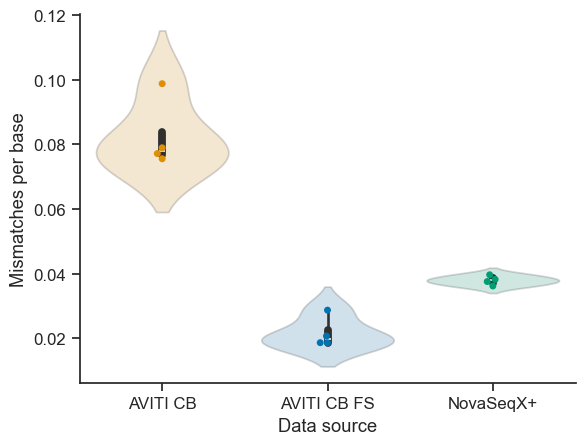

In [8]:
d = data_inv.copy()
positions = list(np.arange(int(150*0.5), int(150*0.6)))
positions += list(np.arange(int(150*0.5), int(150*0.6)) + 150)
d = d.query("Cycle in @positions")
d = d.groupby(["Data source", "Cell line"]).agg({"Mismatches per base": "median"}).reset_index()
sns.swarmplot(d, x="Data source", y="Mismatches per base", hue="Data source", hue_order=run_names.values())
sns.violinplot(d, x="Data source", y="Mismatches per base", hue="Data source", hue_order=run_names.values(), alpha=0.2)
print(d.groupby(["Data source"]).agg({"Mismatches per base": ["min", "max"]}))